# Importing Data into SingleTree 🌲

Welcome to the SingleTree demo! In this notebook we show how to create a minimal dataset
and import various measurement types — field inventory, drone LiDAR (ULS), harvester
production files, and CT scans. The example data is synthetic and lives in the `notebooks`
directory for convenience.

We first set up our environment and generate a demo dataset using a helper script.

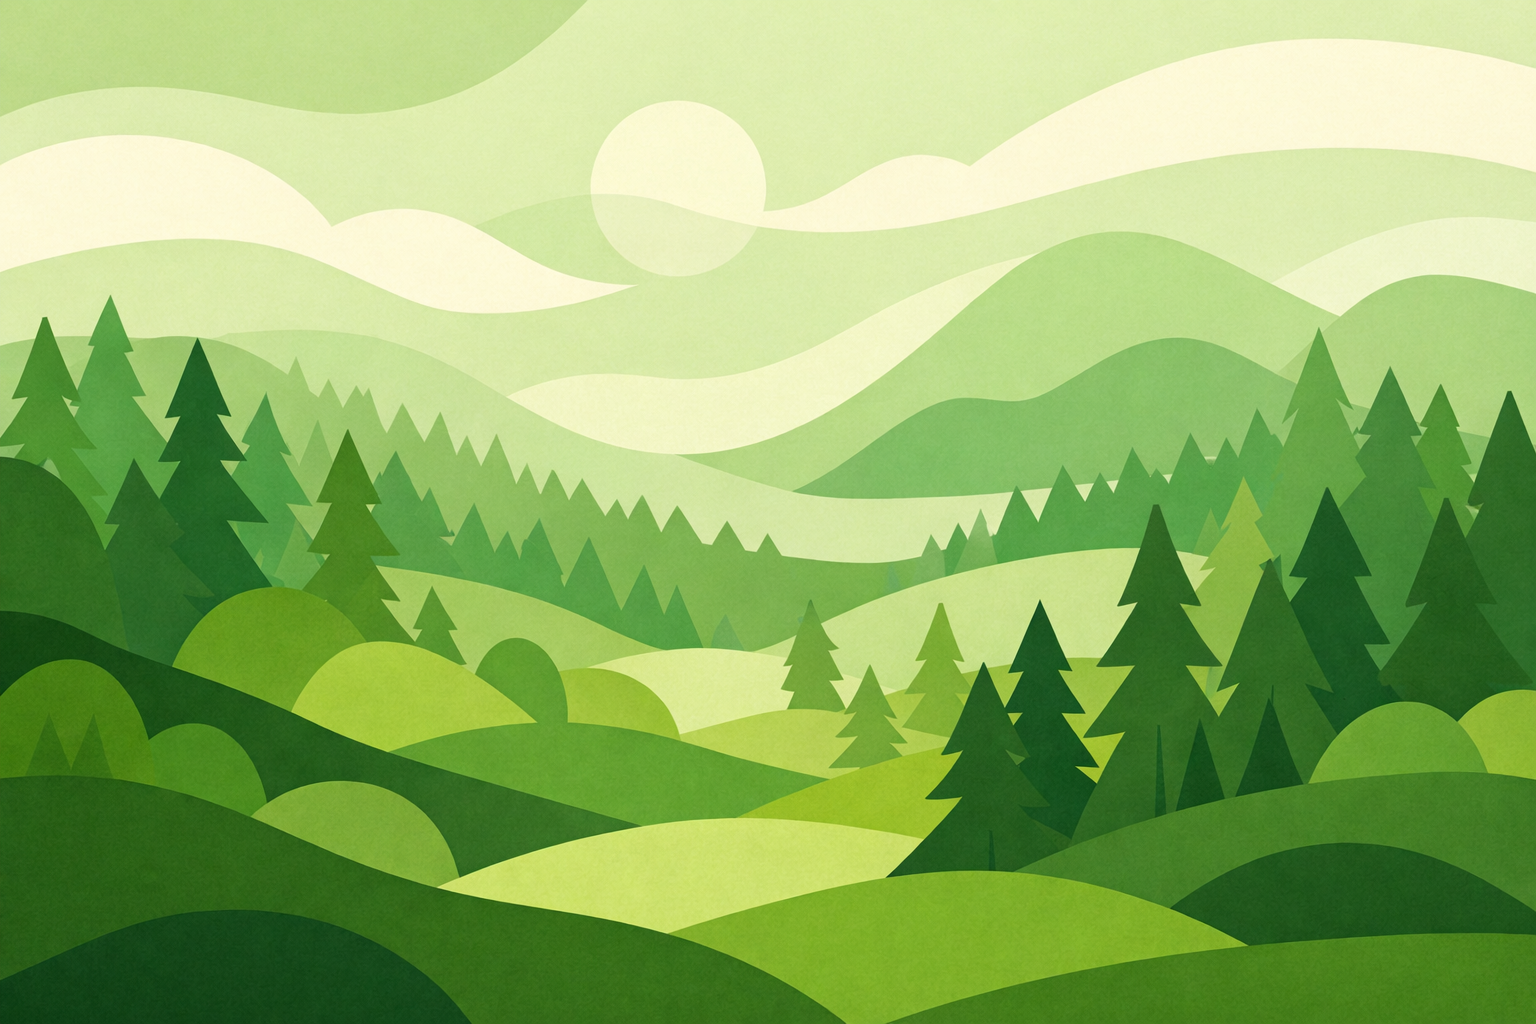

In [ ]:
# Run the helper script to create the demo GeoPackage and point clouds.
# This script comes with the repository and produces demo_data.gpkg and two CSVs
# containing the tree pack and ground-only points.
import subprocess
subprocess.run(["python3", "create_demo_data.py"], check=True)


In [ ]:
# Inspect the basic contents of the database
import sqlite3
conn = sqlite3.connect("notebooks/demo_data.gpkg")
c = conn.cursor()
print('Trees:', c.execute('SELECT COUNT(*) FROM trees').fetchone()[0])
print('Measurements:', c.execute('SELECT COUNT(*) FROM measurements').fetchone()[0])
print('Assets:', c.execute('SELECT COUNT(*) FROM assets').fetchone()[0])
conn.close()


### Importing LiDAR data

To import LiDAR point clouds you can use `singletree.ingest.lidar.import_campaign_tree_packs`.
This function reads one or more LAZ files with per‑point instance and semantic labels and writes
out tree packs, ground-only and residual clouds. It returns a list of asset records for
insertion into the database. For the demo we skip executing it because our dataset already
includes a CSV-based tree pack, but here is how you would call it on your own data:

In [ ]:
from singletree.ingest.lidar import import_campaign_tree_packs

assets = import_campaign_tree_packs(
    campaign_uid='MLS_2025-06-01_STAND001',
    input_paths=['/path/to/MLS_2025-06-01_tile1.laz', '/path/to/MLS_2025-06-01_tile2.laz'],
    instance_dim='instance_pred',
    semantic_dim='semantic_pred',
    score_dim='score',
    ground_classes=[1],
    tree_classes=[2, 3],
    output_root='pointclouds/campaigns'
)

# `assets` is a list of dictionaries describing the generated LAZ files
for asset in assets:
    print(asset)


### Importing harvester production files

The `optbuck` package (already ported to Python) parses StanForD 2010 `.hpr` files.
Use `singletree.ingest.harvester_hpr.import_harvester_hpr` to extract stems, logs,
stem profiles and price matrices. The importer copies the raw HPR into the assets
directory and returns four lists of records you can insert into the relevant tables.

In [ ]:
from singletree.ingest.harvester_hpr import import_harvester_hpr

result = import_harvester_hpr(
    hpr_path='/path/to/harvester_data.hpr',
    campaign_uid='HARV_2025-06-02_STAND001',
    output_root='pointclouds/campaigns'
)

print('Assets:', result['asset_record'])
print('Stems:', result['stems'][:2])
print('Logs:', result['logs'][:2])
print('Stem profile:', result['stem_profile'][:2])
print('Price matrix:', result['price_matrix'][:2])


### Importing CT scan data

CT scan results are often provided as CSV files or structured tables rather than
point clouds. You can load them into the `ct_metrics` table directly with a SQL
`INSERT`. For example:

In [ ]:
import sqlite3
conn = sqlite3.connect('notebooks/demo_data.gpkg')
c = conn.cursor()

# Insert a sample CT metric (normally you would load this from a file)
c.execute(
    'INSERT INTO ct_metrics (measurement_uid, metric_id, knot_count, max_knot_diameter_cm,'
    ' mean_ring_width_mm, density_kg_m3, description)'
    ' VALUES (?, ?, ?, ?, ?, ?, ?)',
    (
        'T002_CT_2025-01-05',
        'm2',
        4,
        3.5,
        2.0,
        540.0,
        'Second CT scan'
    )
)
conn.commit()
conn.close()


You now have a feel for how to load different types of data into SingleTree.
The next notebook demonstrates how the matching mechanism works and how to query trees.